<a href="https://colab.research.google.com/github/peterbmob/WP2pres/blob/main/xTBCCSFNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#xTB+fortnet

In [3]:
#@title Create environment
# Conda is uninstalled every time you rehash yuor environment... 
#!conda --version
#If !conda --version returns no results, install conda with :
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:25
🔁 Restarting kernel...


In [2]:
#@title First, let's install MAMBA and dftbplus using conda
%%capture
!conda install -c conda-forge mamba dftbplus 

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

# All requested packages already installed.



In [3]:
#@title Install Fortnet
%%capture
!mamba install 'fortnet=*=nompi_*'


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['fortnet=[build=nompi_*]']

conda-forge/linux-64                                        Using cache

In [4]:
#@title and fortnet-ase and CCS
%%capture
!pip install fortnet-ase 
!pip install git+https://github.com/Teoroo-CMC/CCS.git@remove_key_check

In [106]:
ls

band.out                    detailed.out     output
CCS_error.out               dftb_in.hsd      POSCAR
CCS_input_interpreted.json  dftb_pin.hsd     results.tag
CCS_input.json              fnetdata.hdf5    sample_data/
CCS_params.json             fortnet.hdf5     singlepoint.out
ccs.spl                     fortnet_in.hsd   structures.json
charges.bin                 fortnet_pin.hsd  test.out
condacolab_install.log      geo_end.gen


In [107]:
#@title upload data from disc
from google.colab import files
uploads= files.upload()

Saving DFT_DB_train.db to DFT_DB_train.db
Saving DFT_DB_val.db to DFT_DB_val.db
Saving DFTB_DB_train.db to DFTB_DB_train.db


In [95]:
ls

band.out                    DFTB_DB_train_CCS.db  fortnet_pin.hsd
CCS_error.out               DFTB_DB_train.db      geo_end.gen
CCS_input_interpreted.json  dftb_in.hsd           output
CCS_input.json              dftb_pin.hsd          POSCAR
CCS_params.json             DFT_DB_train.db       sample_data/
ccs.spl                     DFT_DB_val.db         singlepoint.out
charges.bin                 fnetdata.hdf5         structures.json
condacolab_install.log      fortnet.hdf5          test.out
detailed.out                fortnet_in.hsd


In [140]:
#@title Defs to run fornet and xTB
def write_fnet_input(outfile, **kwargs):
   outfile.write('Network = BPNN { \n')
   outfile.write('  Hidden = 5 5 \n')
   outfile.write('  Activation = tanh \n')
   outfile.write('} \n')
   outfile.write(' \n')

   outfile.write('Features { \n')
   outfile.write('  Mapping = ACSF { \n')
   outfile.write('    Reduce = No \n')
   outfile.write('    Standardization = Yes \n')
   outfile.write('    Function = Auto {\n')
   outfile.write('      Rcut = 4.0 \n')
   outfile.write('      Nradial = 5 \n')
   outfile.write('      NAngular = 4 \n')
   outfile.write('    } \n')
   outfile.write('  } \n')
   outfile.write('} \n')
   outfile.write(' \n')

   outfile.write('Training = LBFGS { \n')
   outfile.write('  Threshold = 1e-8  \n')
   outfile.write('  NIterations = 5000 \n')
   outfile.write('  NPrintout = 1000 \n')
   outfile.write('  NSaveNet = 1000 \n')
   outfile.write('  MinDisplacement = 1e-10 \n')
   outfile.write('  MaxDispacement = 5e-02 \n')
   outfile.write('  LineMin = Yes \n')
   outfile.write('  Memory =1000 \n')
   outfile.write('  Loss = mse \n')
   outfile.write('} \n')
   outfile.write(' \n')

   outfile.write('Data {  \n')
   outfile.write('  Dataset = fnetdata.hdf5 \n')
   outfile.write('  Netstatfile ='+"'"+'fortnet.hdf5'+"'"+'\n') 
   outfile.write('} \n')
   outfile.write(' \n')

   outfile.write('Options { \n')
   outfile.write('  Mode = train \n')
   outfile.write('  ReadNetStats = No \n')
   outfile.write('  RandomSeed = 123456 \n')
   outfile.write('} \n')
   outfile.write(' \n')

def fnet_validate(outfile):
   outfile.write('Data {  \n')
   outfile.write('  Dataset = fnetdata.hdf5 \n')
   outfile.write('  Netstatfile = fortnet.hdf5 \n') 
   outfile.write('} \n')
   outfile.write(' \n')

   outfile.write('Options { \n')
   outfile.write('  Mode = validate \n')
   outfile.write('  ReadNetStats = Yes \n')
   outfile.write('} \n')
   outfile.write(' \n')  
   

""" This module defines a FileIOCalculator for DFTB+ with XTB 

http://www.dftbplus.org/
http://www.dftb.org/

Initial development: markus.kaukonen@iki.fi, Modified to be used with xTB. 
"""

import os
import numpy as np
from ase.calculators.calculator import (FileIOCalculator, kpts2ndarray,
                                        kpts2sizeandoffsets)
from ase.units import Hartree, Bohr


class Dftb_xtb(FileIOCalculator):

    command = 'dftb+ > PREFIX.out'

    implemented_properties = ['energy', 'forces', 'charges',
                              'stress', 'dipole']
    discard_results_on_any_change = True

    def __init__(self, restart=None,
                 ignore_bad_restart_file=FileIOCalculator._deprecated,
                 label='dftb', atoms=None, kpts=None,
                 slako_dir=None,
                 **kwargs):
        """
        All keywords for the dftb_in.hsd input file (see the DFTB+ manual)
        can be set by ASE. Consider the following input file block:

        >>> Hamiltonian = DFTB {
        >>>     SCC = Yes
        >>>     SCCTolerance = 1e-8
        >>>     MaxAngularMomentum = {
        >>>         H = s
        >>>         O = p
        >>>     }
        >>> }

        This can be generated by the DFTB+ calculator by using the
        following settings:

        >>> calc = Dftb(Hamiltonian_='DFTB',  # line is included by default
        >>>             Hamiltonian_SCC='Yes',
        >>>             Hamiltonian_SCCTolerance=1e-8,
        >>>             Hamiltonian_MaxAngularMomentum_='',
        >>>             Hamiltonian_MaxAngularMomentum_H='s',
        >>>             Hamiltonian_MaxAngularMomentum_O='p')

        In addition to keywords specific to DFTB+, also the following keywords
        arguments can be used:

        restart: str
            Prefix for restart file.  May contain a directory.
            Default is None: don't restart.
        ignore_bad_restart_file: bool
            Ignore broken or missing restart file. By default, it is an
            error if the restart file is missing or broken.
        label: str (default 'dftb')
            Prefix used for the main output file (.out).
        atoms: Atoms object (default None)
            Optional Atoms object to which the calculator will be
            attached. When restarting, atoms will get its positions and
            unit-cell updated from file.
        kpts: (default None)
            Brillouin zone sampling:

            * ``(1,1,1)`` or ``None``: Gamma-point only
            * ``(n1,n2,n3)``: Monkhorst-Pack grid
            * ``dict``: Interpreted as a path in the Brillouin zone if
              it contains the 'path_' keyword. Otherwise it is converted
              into a Monkhorst-Pack grid using
              ``ase.calculators.calculator.kpts2sizeandoffsets``
            * ``[(k11,k12,k13),(k21,k22,k23),...]``: Explicit (Nkpts x 3)
              array of k-points in units of the reciprocal lattice vectors
              (each with equal weight)

        Additional attribute to be set by the embed() method:

        pcpot: PointCharge object
            An external point charge potential (for QM/MM calculations)
        """

        #if slako_dir is None:
            #slako_dir = os.environ.get('DFTB_PREFIX', './')
            #if not slako_dir.endswith('/'):
            #    slako_dir += '/'

        #self.slako_dir = slako_dir

        self.default_parameters = dict(
            Hamiltonian_='DFTB',
         #   Hamiltonian_SlaterKosterFiles_='Type2FileNames',
         #   Hamiltonian_SlaterKosterFiles_Prefix=self.slako_dir,
         #  Hamiltonian_SlaterKosterFiles_Separator='"-"',
         #   Hamiltonian_SlaterKosterFiles_Suffix='".skf"',
         #   Hamiltonian_MaxAngularMomentum_='',
            Paralell_='',
            Paralell_UseOmpThreads = 'Yes', 
            Analysis_='',  
            Analysis_CalculateForces = 'Yes',   
            Options_='',
            Options_WriteResultsTag='Yes')
   

        self.pcpot = None
        self.lines = None
        self.atoms = None
        self.atoms_input = None
        self.do_forces = True 
        self.outfilename = 'dftb.out'

        FileIOCalculator.__init__(self, restart, ignore_bad_restart_file,
                                  label, atoms,
                                  **kwargs)

        # Determine number of spin channels
        try:
            entry = kwargs['Hamiltonian_SpinPolarisation']
            spinpol = 'colinear' in entry.lower()
        except KeyError:
            spinpol = False
        self.nspin = 2 if spinpol else 1

        # kpoint stuff by ase
        self.kpts = kpts
        self.kpts_coord = None

        if self.kpts is not None:
            initkey = 'Hamiltonian_KPointsAndWeights'
            mp_mesh = None
            offsets = None

            if isinstance(self.kpts, dict):
                if 'path' in self.kpts:
                    # kpts is path in Brillouin zone
                    self.parameters[initkey + '_'] = 'Klines '
                    self.kpts_coord = kpts2ndarray(self.kpts, atoms=atoms)
                else:
                    # kpts is (implicit) definition of
                    # Monkhorst-Pack grid
                    self.parameters[initkey + '_'] = 'SupercellFolding '
                    mp_mesh, offsets = kpts2sizeandoffsets(atoms=atoms,
                                                           **self.kpts)
            elif np.array(self.kpts).ndim == 1:
                # kpts is Monkhorst-Pack grid
                self.parameters[initkey + '_'] = 'SupercellFolding '
                mp_mesh = self.kpts
                offsets = [0.] * 3
            elif np.array(self.kpts).ndim == 2:
                # kpts is (N x 3) list/array of k-point coordinates
                # each will be given equal weight
                self.parameters[initkey + '_'] = ''
                self.kpts_coord = np.array(self.kpts)
            else:
                raise ValueError('Illegal kpts definition:' + str(self.kpts))

            if mp_mesh is not None:
                eps = 1e-10
                for i in range(3):
                    key = initkey + '_empty%03d' % i
                    val = [mp_mesh[i] if j == i else 0 for j in range(3)]
                    self.parameters[key] = ' '.join(map(str, val))
                    offsets[i] *= mp_mesh[i]
                    assert abs(offsets[i]) < eps or abs(offsets[i] - 0.5) < eps
                    # DFTB+ uses a different offset convention, where
                    # the k-point mesh is already Gamma-centered prior
                    # to the addition of any offsets
                    if mp_mesh[i] % 2 == 0:
                        offsets[i] += 0.5
                key = initkey + '_empty%03d' % 3
                self.parameters[key] = ' '.join(map(str, offsets))

            elif self.kpts_coord is not None:
                for i, c in enumerate(self.kpts_coord):
                    key = initkey + '_empty%09d' % i
                    c_str = ' '.join(map(str, c))
                    if 'Klines' in self.parameters[initkey + '_']:
                        c_str = '1 ' + c_str
                    else:
                        c_str += ' 1.0'
                    self.parameters[key] = c_str

    def write_dftb_in(self, outfile):
        """ Write the innput file for the dftb+ calculation.
            Geometry is taken always from the file 'geo_end.gen'.
        """

        outfile.write('Geometry = GenFormat { \n')
        outfile.write('    <<< "geo_end.gen" \n')
        outfile.write('} \n')
        outfile.write(' \n')

        params = self.parameters.copy()

        #s = 'Hamiltonian_MaxAngularMomentum_'
        #for key in params:
        #    if key.startswith(s) and len(key) > len(s):
        #        break
        #else:
            # User didn't specify max angular mometa.  Get them from
            # the .skf files:
        #    symbols = set(self.atoms.get_chemical_symbols())
        #    for symbol in symbols:
        #        path = os.path.join(self.slako_dir,
        #                            '{0}-{0}.skf'.format(symbol))
        #        l = read_max_angular_momentum(path)
        #        params[s + symbol] = '"{}"'.format('spdf'[l])

        # --------MAIN KEYWORDS-------
        previous_key = 'dummy_'
        myspace = ' '
        for key, value in sorted(params.items()):
            current_depth = key.rstrip('_').count('_')
            previous_depth = previous_key.rstrip('_').count('_')
            for my_backsclash in reversed(
                    range(previous_depth - current_depth)):
                outfile.write(3 * (1 + my_backsclash) * myspace + '} \n')
            outfile.write(3 * current_depth * myspace)
            if key.endswith('_') and len(value) > 0:
                outfile.write(key.rstrip('_').rsplit('_')[-1] +
                              ' = ' + str(value) + '{ \n')
            elif (key.endswith('_') and (len(value) == 0)
                  and current_depth == 0):  # E.g. 'Options {'
                outfile.write(key.rstrip('_').rsplit('_')[-1] +
                              ' ' + str(value) + '{ \n')
            elif (key.endswith('_') and (len(value) == 0)
                  and current_depth > 0):  # E.g. 'Hamiltonian_Max... = {'
                outfile.write(key.rstrip('_').rsplit('_')[-1] +
                              ' = ' + str(value) + '{ \n')
            elif key.count('_empty') == 1:
                outfile.write(str(value) + ' \n')
            elif ((key == 'Hamiltonian_ReadInitialCharges') and
                  (str(value).upper() == 'YES')):
                f1 = os.path.isfile(self.directory + os.sep + 'charges.dat')
                f2 = os.path.isfile(self.directory + os.sep + 'charges.bin')
                if not (f1 or f2):
                    print('charges.dat or .bin not found, switching off guess')
                    value = 'No'
                outfile.write(key.rsplit('_')[-1] + ' = ' + str(value) + ' \n')
            else:
                outfile.write(key.rsplit('_')[-1] + ' = ' + str(value) + ' \n')
            if self.pcpot is not None and ('DFTB' in str(value)):
                outfile.write('   ElectricField = { \n')
                outfile.write('      PointCharges = { \n')
                outfile.write(
                    '         CoordsAndCharges [Angstrom] = DirectRead { \n')
                outfile.write('            Records = ' +
                              str(len(self.pcpot.mmcharges)) + ' \n')
                outfile.write(
                    '            File = "dftb_external_charges.dat" \n')
                outfile.write('         } \n')
                outfile.write('      } \n')
                outfile.write('   } \n')
            previous_key = key
        current_depth = key.rstrip('_').count('_')
        for my_backsclash in reversed(range(current_depth)):
            outfile.write(3 * my_backsclash * myspace + '} \n')
        outfile.write('ParserOptions { \n')
        outfile.write('   IgnoreUnprocessedNodes = Yes  \n')
        outfile.write('} \n')
        if self.do_forces:
            outfile.write('Analysis { \n')
            outfile.write('   CalculateForces = Yes  \n')
            outfile.write('} \n')

    def check_state(self, atoms):
        system_changes = FileIOCalculator.check_state(self, atoms)
        # Ignore unit cell for molecules:
        if not atoms.pbc.any() and 'cell' in system_changes:
            system_changes.remove('cell')
        if self.pcpot and self.pcpot.mmpositions is not None:
            system_changes.append('positions')
        return system_changes

    def write_input(self, atoms, properties=None, system_changes=None):
        from ase.io import write
        if properties is not None:
            if 'forces' in properties or 'stress' in properties:
                self.do_forces = True
        FileIOCalculator.write_input(
            self, atoms, properties, system_changes)
        with open(os.path.join(self.directory, 'dftb_in.hsd'), 'w') as fd:
            self.write_dftb_in(fd)
        write(os.path.join(self.directory, 'geo_end.gen'), atoms,
              parallel=False)
        # self.atoms is none until results are read out,
        # then it is set to the ones at writing input
        self.atoms_input = atoms
        self.atoms = None
        if self.pcpot:
            self.pcpot.write_mmcharges('dftb_external_charges.dat')

    def read_results(self):
        """ all results are read from results.tag file
            It will be destroyed after it is read to avoid
            reading it once again after some runtime error """

        with open(os.path.join(self.directory, 'results.tag'), 'r') as fd:
            self.lines = fd.readlines()

        self.atoms = self.atoms_input
        charges, energy, dipole = self.read_charges_energy_dipole()
        if charges is not None:
            self.results['charges'] = charges
        self.results['energy'] = energy
        if dipole is not None:
            self.results['dipole'] = dipole
        if self.do_forces:
            forces = self.read_forces()
            self.results['forces'] = forces
        self.mmpositions = None

        # stress stuff begins
        sstring = 'stress'
        have_stress = False
        stress = list()
        for iline, line in enumerate(self.lines):
            if sstring in line:
                have_stress = True
                start = iline + 1
                end = start + 3
                for i in range(start, end):
                    cell = [float(x) for x in self.lines[i].split()]
                    stress.append(cell)
        if have_stress:
            stress = -np.array(stress) * Hartree / Bohr**3
            self.results['stress'] = stress.flat[[0, 4, 8, 5, 2, 1]]
        # stress stuff ends

        # eigenvalues and fermi levels
        fermi_levels = self.read_fermi_levels()
        if fermi_levels is not None:
            self.results['fermi_levels'] = fermi_levels

        eigenvalues = self.read_eigenvalues()
        if eigenvalues is not None:
            self.results['eigenvalues'] = eigenvalues

        # calculation was carried out with atoms written in write_input
        os.remove(os.path.join(self.directory, 'results.tag'))

    def read_forces(self):
        """Read Forces from dftb output file (results.tag)."""
        from ase.units import Hartree, Bohr

        # Initialise the indices so their scope
        # reaches outside of the for loop
        index_force_begin = -1
        index_force_end = -1

        # Force line indexes
        for iline, line in enumerate(self.lines):
            fstring = 'forces   '
            if line.find(fstring) >= 0:
                index_force_begin = iline + 1
                line1 = line.replace(':', ',')
                index_force_end = iline + 1 + \
                    int(line1.split(',')[-1])
                break

        gradients = []
        for j in range(index_force_begin, index_force_end):
            word = self.lines[j].split()
            gradients.append([float(word[k]) for k in range(0, 3)])

        return np.array(gradients) * Hartree / Bohr

    def read_charges_energy_dipole(self):
        """Get partial charges on atoms
            in case we cannot find charges they are set to None
        """
        with open(os.path.join(self.directory, 'detailed.out'), 'r') as fd:
            lines = fd.readlines()

        for line in lines:
            if line.strip().startswith('Total energy:'):
                energy = float(line.split()[2]) * Hartree
                break

        qm_charges = []
        for n, line in enumerate(lines):
            if ('Atom' and 'Charge' in line):
                chargestart = n + 1
                break
        else:
            # print('Warning: did not find DFTB-charges')
            # print('This is ok if flag SCC=No')
            return None, energy, None

        lines1 = lines[chargestart:(chargestart + len(self.atoms))]
        for line in lines1:
            qm_charges.append(float(line.split()[-1]))

        dipole = None
        for line in lines:
            if 'Dipole moment:' in line and 'au' in line:
                words = line.split()
                dipole = np.array(
                    [float(w) for w in words[-4:-1]]) * Bohr

        return np.array(qm_charges), energy, dipole

    def get_charges(self, atoms):
        """ Get the calculated charges
        this is inhereted to atoms object """
        if 'charges' in self.results:
            return self.results['charges']
        else:
            return None

    def read_eigenvalues(self):
        """ Read Eigenvalues from dftb output file (results.tag).
            Unfortunately, the order seems to be scrambled. """
        # Eigenvalue line indexes
        index_eig_begin = None
        for iline, line in enumerate(self.lines):
            fstring = 'eigenvalues   '
            if line.find(fstring) >= 0:
                index_eig_begin = iline + 1
                line1 = line.replace(':', ',')
                ncol, nband, nkpt, nspin = map(int, line1.split(',')[-4:])
                break
        else:
            return None

        # Take into account that the last row may lack
        # columns if nkpt * nspin * nband % ncol != 0
        nrow = int(np.ceil(nkpt * nspin * nband * 1. / ncol))
        index_eig_end = index_eig_begin + nrow
        ncol_last = len(self.lines[index_eig_end - 1].split())
        self.lines[index_eig_end - 1] += ' 0.0 ' * (ncol - ncol_last)

        eig = np.loadtxt(self.lines[index_eig_begin:index_eig_end]).flatten()
        eig *= Hartree
        N = nkpt * nband
        eigenvalues = [eig[i * N:(i + 1) * N].reshape((nkpt, nband))
                       for i in range(nspin)]

        return eigenvalues

    def read_fermi_levels(self):
        """ Read Fermi level(s) from dftb output file (results.tag). """
        # Fermi level line indexes
        for iline, line in enumerate(self.lines):
            fstring = 'fermi_level   '
            if line.find(fstring) >= 0:
                index_fermi = iline + 1
                break
        else:
            return None

        fermi_levels = []
        words = self.lines[index_fermi].split()
        assert len(words) in [1, 2], 'Expected either 1 or 2 Fermi levels'

        for word in words:
            e = float(word)
            # In non-spin-polarized calculations with DFTB+ v17.1,
            # two Fermi levels are given, with the second one being 0,
            # but we don't want to add that one to the list
            if abs(e) > 1e-8:
                fermi_levels.append(e)

        return np.array(fermi_levels) * Hartree

    def get_ibz_k_points(self):
        return self.kpts_coord.copy()

    def get_number_of_spins(self):
        return self.nspin

    def get_eigenvalues(self, kpt=0, spin=0):
        return self.results['eigenvalues'][spin][kpt].copy()

    def get_fermi_levels(self):
        return self.results['fermi_levels'].copy()

    def get_fermi_level(self):
        return max(self.get_fermi_levels())

    def embed(self, mmcharges=None, directory='./'):
        """Embed atoms in point-charges (mmcharges)
        """
        self.pcpot = PointChargePotential(mmcharges, self.directory)
        return self.pcpot



class PointChargePotential:
    def __init__(self, mmcharges, directory='./'):
        """Point-charge potential for DFTB+.
        """
        self.mmcharges = mmcharges
        self.directory = directory
        self.mmpositions = None
        self.mmforces = None

    def set_positions(self, mmpositions):
        self.mmpositions = mmpositions

    def set_charges(self, mmcharges):
        self.mmcharges = mmcharges

    def write_mmcharges(self, filename):
        """ mok all
        write external charges as monopoles for dftb+.

        """
        if self.mmcharges is None:
            print("DFTB: Warning: not writing exernal charges ")
            return
        with open(os.path.join(self.directory, filename), 'w') as charge_file:
            for [pos, charge] in zip(self.mmpositions, self.mmcharges):
                [x, y, z] = pos
                charge_file.write('%12.6f %12.6f %12.6f %12.6f \n'
                                  % (x, y, z, charge))

    def get_forces(self, calc, get_forces=True):
        """ returns forces on point charges if the flag get_forces=True """
        if get_forces:
            return self.read_forces_on_pointcharges()
        else:
            return np.zeros_like(self.mmpositions)

    def read_forces_on_pointcharges(self):
        """Read Forces from dftb output file (results.tag)."""
        from ase.units import Hartree, Bohr
        with open(os.path.join(self.directory, 'detailed.out'), 'r') as fd:
            lines = fd.readlines()

        external_forces = []
        for n, line in enumerate(lines):
            if ('Forces on external charges' in line):
                chargestart = n + 1
                break
        else:
            raise RuntimeError(
                'Problem in reading forces on MM external-charges')
        lines1 = lines[chargestart:(chargestart + len(self.mmcharges))]
        for line in lines1:
            external_forces.append(
                [float(i) for i in line.split()])
        return np.array(external_forces) * Hartree / Bohr

def read_max_angular_momentum(path):
    """Read maximum angular momentum from .skf file.

    See dftb.org for A detailed description of the Slater-Koster file format.
    """
    with open(path, 'r') as fd:
        line = fd.readline()
        if line[0] == '@':
            # Extended format
            fd.readline()
            l = 3
            pos = 9
        else:
            # Simple format:
            l = 2
            pos = 7

        # Sometimes there ar commas, sometimes not:
        line = fd.readline().replace(',', ' ')

        occs = [float(f) for f in line.split()[pos:pos + l + 1]]
        for f in occs:
            if f > 0.0:
                return l
            l -= 1

def setup_model_xtb(atoms, charge=0,init=True):
    from ase.calculators.mixing import LinearCombinationCalculator

#    print('setting up calculator')
    if init==True:
        DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_Mixer= 'Anderson{',Hamiltonian_Mixer_MixingParameter='0.03',Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_Filling = 'MethfesselPaxton{',Hamiltonian_Filling_Temperature = '0.001583407672623195',Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if init==False:
          DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_ReadInitialCharges='Yes', Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_AdaptFillingTemp = 'yes', Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if charge>0: 
        DFTB_calc.set(Hamiltonian_Charge =str(charge))

#    CCS_calc=CCS(CCS_params=CCS_params) 
    calcs =[DFTB_calc] #, PiNN_calc]
    weights=[1] #,1]
    calc=LinearCombinationCalculator(calcs, weights) 
    return calc     


def setup_model_xtb_ccs(atoms, CCS_params, charge=0,init=True):
    from ase.calculators.mixing import LinearCombinationCalculator

#    print('setting up calculator')
    if init==True:
        DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_Mixer= 'Anderson{',Hamiltonian_Mixer_MixingParameter='0.03',Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_Filling = 'MethfesselPaxton{',Hamiltonian_Filling_Temperature = '0.001583407672623195',Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if init==False:
          DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_ReadInitialCharges='Yes', Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_AdaptFillingTemp = 'yes', Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if charge>0: 
        DFTB_calc.set(Hamiltonian_Charge =str(charge))
    
    CCS_calc=CCS(CCS_params=CCS_params) 
    calcs =[DFTB_calc, CCS_calc]
    weights=[1,1] #,1]
    calc=LinearCombinationCalculator(calcs, weights) 
    return calc     

def setup_model_xtb_fnet(atoms, charge=0,init=True):
    from ase.calculators.mixing import LinearCombinationCalculator

#    print('setting up calculator')
    if init==True:
        DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_Mixer= 'Anderson{',Hamiltonian_Mixer_MixingParameter='0.03',Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_Filling = 'MethfesselPaxton{',Hamiltonian_Filling_Temperature = '0.001583407672623195',Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if init==False:
          DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_ReadInitialCharges='Yes', Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_AdaptFillingTemp = 'yes', Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if charge>0: 
        DFTB_calc.set(Hamiltonian_Charge =str(charge))

#    CCS_calc=CCS(CCS_params=CCS_params) 
    FNET_calc = Fortnet(label='test', atoms=system, restart='fortnet.hdf5')
    FNET_calc.calculate(atoms=system, properties=('energy', 'forces'))
    
    calcs =[DFTB_calc, FNET_calc] #, PiNN_calc]
    weights=[1,1] #,1]
    calc=LinearCombinationCalculator(calcs, weights) 
    return calc     

def setup_model_xtb_ccs_fnet(atoms, charge=0,init=True):
    from ase.calculators.mixing import LinearCombinationCalculator

#   print('setting up calculator')
    if init==True:
        DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_Mixer= 'Anderson{',Hamiltonian_Mixer_MixingParameter='0.03',Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_Filling = 'MethfesselPaxton{',Hamiltonian_Filling_Temperature = '0.001583407672623195',Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if init==False:
          DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_ReadInitialCharges='Yes', Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_AdaptFillingTemp = 'yes', Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if charge>0: 
        DFTB_calc.set(Hamiltonian_Charge =str(charge))
    with open('CCS_params.json', 'r') as f:
        CCS_params = json.load(f)

    CCS_calc=CCS(CCS_params=CCS_params) 
    FNET_calc = Fortnet(label='test', atoms=system, restart='fortnet.hdf5')
    FNET_calc.calculate(atoms=system, properties=('energy', 'forces'),)
    
    calcs =[DFTB_calc, CCS_calc, FNET_calc] #, PiNN_calc]
    weights=[1,1,1] #,1]
    calc=LinearCombinationCalculator(calcs, weights) 
    return calc     

def run_geom(slab,charge):
    charge=charge
    print(slab.calc)
    relax = FIRE(slab, trajectory='opt.traj')
    relax.run(fmax=0.05)

def run_sp(slab,charge):
    charge=charge
    print(slab.calc)
    relax = FIRE(slab, trajectory='opt.traj')
    relax.run(steps=0)

In [99]:
#@title Run xTB on ase db 
import os 
import sys
from ase import Atoms
from ase.db import connect 
from ase import io
import ase.db 

from ase.optimize import FIRE, QuasiNewton
from ase.io import read, write
import ase.db  
from ase.units import *
import numpy as np


  


In [ ]:
## %%capture
db_dft=connect('../DFT_DB_train.db')
db_new=connect('DFTB_DB_train.db')

for row in db.select():
  atoms=row.toatoms()
  print(atoms)
  atoms.calc=setup_model_xtb(atoms)
  atoms.get_potential_energy()
  atoms.get_forces()
  db_new.write(atoms)
  print('Atom id:',row.id,' added')

Text(0, 0.5, 'xTB (eV/atom)')

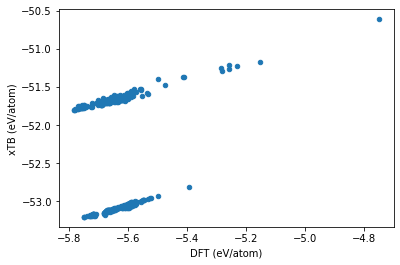

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
Databases = ['DFT_DB_train.db', 'DFTB_DB_train.db']

train=pd.DataFrame()
for database in Databases:
  db=connect(database)
  Energy=[]
  for row in db.select(): 
      Energy.append(row.energy/len(row.toatoms()))
  train[database]=Energy


ax=train.plot.scatter(x=Databases[0],y=Databases[1])
ax = plt.gca()
#ax.set_aspect(1)
ax.set_xlabel('DFT (eV/atom)')
ax.set_ylabel('xTB (eV/atom)')

In [ ]:
from google.colab import files
files.download('DFTB_DB_train.db')

In [109]:
#@title Train CCS model
from ccs_fit.scripts.ccs_fetch import ccs_fetch as ccs_fetch
from ccs_fit.fitting.main import twp_fit as ccs_fit
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
import json

# 1. fetch the data

ccs_fetch(mode='DFTB', R_c= 6.0, Ns='all', DFT_DB='DFT_DB_train.db', DFTB_DB='DFTB_DB_train.db', include_forces=False)



    Fetching data: 100%|██████████| 400/400 [00:09<00:00, 40.58it/s]


In [110]:
# 2. Generate input file 
import json

input={
    "General": {
        "interface": "DFTB",
        "merging"  : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [111]:
# 3. Solve the quadratic programming problem to generate a CCS repulsive potential
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['C', 'H', 'Li', 'O']
    Generating two-body potentials from one-body information.
    Adding pair: C-C
    Adding pair: C-H
    Adding pair: C-Li
    Adding pair: C-O
    Adding pair: H-H
    Adding pair: H-Li
    Adding pair: H-O
    Adding pair: Li-Li
    Adding pair: Li-O
    Adding pair: O-O
    Applying monotonous constraints for pair:  C-C
    Applying monotonous constraints for pair:  C-H
    Applying monotonous constraints for pair:  C-Li
    Applying monotonous constraints for pair:  C-O
    Applying monotonous constraints for pair:  H-H
    Applying monotonous constraints for pair:  H-Li
    Applying monotonous constraints for pair:  H-O
    Applying monotonous constraints for pair:  Li-Li
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  O-O
    Merging interval for pair C-C. Number of knots reduced from 356 to 219. 
    Merging interval for pair

    Finding optimum switch: 100%|██████████| 1/1 [00:39<00:00, 39.99s/it]


    The best switch is (219, 342, 392, 365, 189, 365, 400, 38, 370, 283) with mse: 0.011893, corresponding to distances of [3.49 4.4  5.51 4.73 3.46 5.36 5.67 3.51 5.18 4.88] Å for element pairs ['C-C', 'C-H', 'C-Li', 'C-O', 'H-H', 'H-Li', 'H-O', 'Li-Li', 'Li-O', 'O-O'].
    Final root mean square error in energy:  0.009550951163408485  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


In [112]:
%%capture
import json

db_dft=connect('DFT_DB_train.db')
db_ccs=connect('DFTB_DB_train_CCS.db')

with open('CCS_params.json', 'r') as f:
    CCS_params = json.load(f)

for row in db_dft.select():
  atoms=row.toatoms()
  print(atoms)
  atoms.calc=setup_model_xtb_ccs(atoms, CCS_params)
  atoms.get_potential_energy()
  atoms.get_forces()
  db_ccs.write(atoms)
  print('Atom id:',row.id,' added')

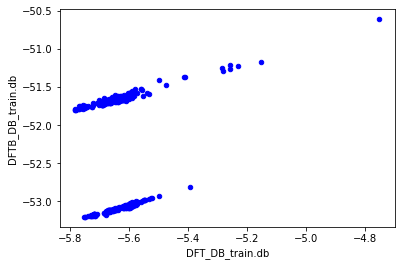

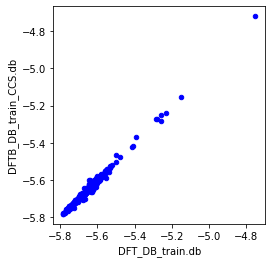

In [118]:
import pandas as pd 
Databases = ['DFT_DB_train.db', 'DFTB_DB_train.db', 'DFTB_DB_train_CCS.db']

train=pd.DataFrame()
for database in Databases:
  db=connect(database)
  Energy=[]
  for row in db.select(): 
      Energy.append(row.energy/len(row.toatoms()))
  train[database]=Energy


train.plot.scatter(x=Databases[0],y=Databases[1], c='b')
train.plot.scatter(x=Databases[0],y=Databases[2],c ='b')
plt.gca().set_aspect('equal')

In [126]:
#@title create FNET trainset from ase db 
from re import DEBUG
import os
import numpy as np
from fortformat import Fnetdata
from ase.db import connect
from ase.io import read, write
from ase.io.vasp import read_vasp, read_vasp_out
from ase import units 

strucs = []
energies =  np.empty((len(db_dft), 1))


ii=-1
for row in db_dft.select():
  ii=ii+1
  atoms=row.toatoms()
  write('POSCAR',atoms)

  strucs.append(read_vasp(os.path.join('POSCAR')))
  energies[ii,0]= ((row.energy-db_ccs.get("id="+str(row.id)).energy)/units.Hartree)   ## UNIT should be in Hartree  

fnetdata = Fnetdata(atoms=strucs, globaltargets=energies)
fnetdata.dump('fnetdata.hdf5')



In [137]:
rm -rf DFTB_DB_train_FNET.db

In [129]:
#@title create FNET input file 
with open('fortnet_in.hsd', 'w') as fd:
            write_fnet_input(fd)





In [130]:
#@title Train FNET 
!fnet | tee output 

|==============================================================================|
|  Fortnet - A BPNN Implementation, Version 0.7.2                              |
|                                                                              |
|  Copyright (C) 2020 - 2022  T. W. van der Heide                              |
|==============================================================================|

date: 06.02.2023
time: 13:48:02, +0000
Interpreting input file 'fortnet_in.hsd'
WARNING!
-> The following 1 node(s) have been ignored by the parser:
(1)
Path: fortnet/Training/LBFGS/MaxDispacement
Line: 24-24 (File: fortnet_in.hsd)

Checking Input Consistency...passed
Processed input written as HSD to 'fortnet_pin.hsd'

--------------------------------------------------------------------------------

Initialisation

running in training mode
random seed: 123456
read initial netstats: F

--------------------------------------------------------------------------------

Sub-NN Details

input

In [141]:
#@title Test xTB+CCS+FNET calculator
from ase.build import molecule
from fnetase import Fortnet
from ase import units


db_fnet=connect('DFTB_DB_train_FNET.db')
energies_trainref=[]
energies_train=[]

for row in db_dft.select():
    system = row.toatoms() 
    energies_trainref.append(row.energy/len(system))
    calc = setup_model_xtb_ccs_fnet(system)
    system.calc=calc
    energy = system.get_potential_energy()
    forces = system.get_forces()
    energies_train.append(energy/len(system))
    db_fnet.write(system)




/usr/local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


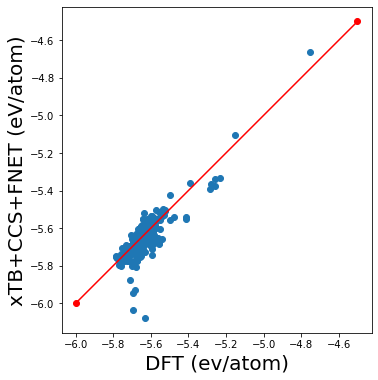

In [142]:
import matplotlib.pyplot as plt


fig1, ax = plt.subplots(figsize=(8, 6))
ax=plt.scatter(energies_trainref,energies_train) 
plt.plot([-6,-4.5], [-6,-4.5], 'ro-')
plt.xlabel('DFT (ev/atom)', fontsize=20)
plt.ylabel('xTB+CCS+FNET (eV/atom)', fontsize=20)
plt.gca().set_aspect('equal')


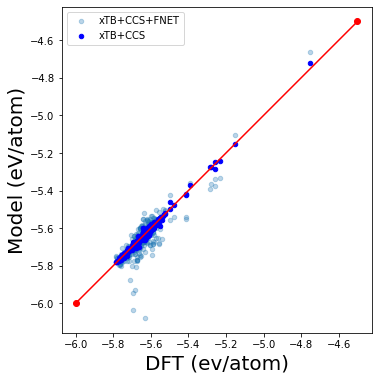

In [154]:
Databases = ['DFT_DB_train.db', 'DFTB_DB_train.db', 'DFTB_DB_train_CCS.db','DFTB_DB_train_FNET.db']

train=pd.DataFrame()
for database in Databases:
  db=connect(database)
  Energy=[]
  for row in db.select(): 
      Energy.append(row.energy/len(row.toatoms()))
  train[database]=Energy


fig1, ax = plt.subplots(figsize=(8, 6))

#train.plot.scatter(x=Databases[0],y=Databases[1], c='b')
train.plot.scatter(x=Databases[0],y=Databases[3], ax=ax, alpha=0.3, label='xTB+CCS+FNET')
train.plot.scatter(x=Databases[0],y=Databases[2], ax=ax, c='b', label='xTB+CCS')
plt.plot([-6,-4.5], [-6,-4.5], 'ro-')
plt.xlabel('DFT (ev/atom)', fontsize=20)
plt.ylabel('Model (eV/atom)', fontsize=20)
ax.legend()
plt.gca().set_aspect('equal')


In [54]:
#@title Validate xTB+FNET calculator
from ase.build import molecule
from fnetase import Fortnet
from ase import units
db_val=connect('DFT_DB_val.db')
energies_valref=[]
energies_val=[]
for row in db_val.select():
    system = row.toatoms() 
    energies_valref.append(row.energy/len(system))
    calc = setup_model_xtb_fnet(system)
    system.calc=calc
    energy = system.get_potential_energy()
    forces = system.get_forces()
    energies_val.append(energy/len(system))


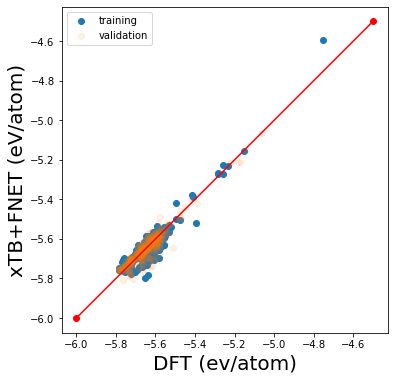

In [82]:
import matplotlib.pyplot as plt
fig2, ax = plt.subplots(figsize=(8, 6))
ax=plt.scatter(energies_trainref,energies_train, label='training') 
plt.scatter(energies_valref,energies_val, label='validation', alpha=0.1)
plt.xlabel('DFT (ev/atom)', fontsize=20)
plt.ylabel('xTB+FNET (eV/atom)', fontsize=20)
plt.plot([-6,-4.5], [-6,-4.5], 'ro-')
plt.legend()
plt.gca().set_aspect('equal')